# 생산부품 예측 Regresson
- 목표 : 부품 Part_Number 별로 D일 투입예정 수량(D일 계획) 예측

### 컬럼설명
- Part_Number : 협력기업에서 모기업에 납품해야하는 부품의 식별자 (id)
- CRET_TIME : 특정부품의 발주 수량이 기록된 해당 시각 정보
- D일 X~XH투입 계획 수량 : 당일(D일)의 시각별 발주 및 계획 발주량
- D일 투입 예정 수량 : 당일(D일)의 통합 발주 및 계획 발주량
- D+X일 투입 예정 수량 : 당일(D일)에 기록된 X일 이후의 계획 발주량

### 데이터 특징
- 데이터기간 : 2021-09-11 ~ 2021-11-01

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import *

pd.set_option('display.max_columns', None)

## 1. 데이터 확인

In [2]:
df_org = pd.read_excel('./data.xls')
df_org

,Part Number,D일06~08(08)H 투입계획(발주) 수량,D일08~10(10)H 투입계획(발주) 수량,D일10~12(13)H 투입계획(발주) 수량,D일13~15(15)H 투입계획(발주) 수량,D일15~17(18)H 투입계획(발주) 수량,D일18~20(21)H 투입계획(발주) 수량,D일21~23(23)H 투입계획(발주) 수량,D일23~01(02)H 투입계획(발주) 수량,D일 02~04H 투입계획 수량,D일 04~06H 투입계획 수량,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(D+1일),D+1일 투입예정 수량(D+1일).1,D+1일 투입예정 수량(D+1일).2,D+1일 투입예정 수량(D+1일).3,D+1일 투입예정 수량(D+1일).4,D+1일 투입예정 수량(D+1일).5,D+1일 투입예정 수량(D+1일).6,D+1일 투입예정 수량(D+1일).7,D+1일 투입예정 수량(D+1일).8,D+1일 투입예정 수량(D+1일).9,D+1일 투입예정 수량(Total),D+2일 투입예정 수량(과부족수량),D+2일 투입예정 수량(과부족수량).1,D+2일 투입예정 수량(과부족수량).2,D+2일 투입예정 수량(과부족수량).3,D+2일 투입예정 수량(과부족수량).4,D+2일 투입예정 수량(과부족수량).5,D+2일 투입예정 수량(과부족수량).6,D+2일 투입예정 수량(과부족수량).7,D+2일 투입예정 수량(과부족수량).8,D+2일 투입예정 수량(과부족수량).9,D+2일 투입예정 수량(Total),D+3일 투입예정 수량(과부족수량),D+3일 투입예정 수량(과부족수량).1,D+3일 투입예정 수량(과부족수량).2,D+3일 투입예정 수량(과부족수량).3,D+3일 투입예정 수량(과부족수량).4,D+3일 투입예정 수량(과부족수량).5,D+3일 투입예정 수량(과부족수량).6,D+3일 투입예정 수량(과부족수량).7,D+3일 투입예정 수량(과부족수량).8,D+3일 투입예정 수량(과부족수량).9,D+3일 투입예정 수량(Total),D+4일 투입예정 수량(과부족수량),D+4일 투입예정 수량(과부족수량).1,D+4일 투입예정 수량(과부족수량).2,D+4일 투입예정 수량(과부족수량).3,D+4일 투입예정 수량(과부족수량).4,D+4일 투입예정 수량(과부족수량).5,D+4일 투입예정 수량(과부족수량).6,D+4일 투입예정 수량(과부족수량).7,D+4일 투입예정 수량(과부족수량).8,D+4일 투입예정 수량(과부족수량).9,D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량,D+13일 투입예정 수량,D+14일 투입예정 수량,D+15일 투입예정 수량,D+16일 투입예정 수량,D+17일 투입예정 수량,D+18일 투입예정 수량,D+19일 투입예정 수량,D+20일 투입예정 수량,D+21일 투입예정 수량,D+22일 투입예정 수량,D+23일 투입예정 수량,D+24일 투입예정 수량,D+25일 투입예정 수량,D+26일 투입예정 수량,D+27일 투입예정 수량,D+28일 투입예정 수량,D+29일 투입예정 수량,D+30일 투입예정 수량,D+31~D+45일 투입예정 수량,CRET_TIME
0,Part 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202109131830
1,Part 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,4,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202109131830
2,Part 2,139,60,80,76,68,81,68,44,0,0,616,71,66,84,76,61,90,66,46,0,0,560,75,67,101,63,70,100,72,42,0,0,590,88,72,93,73,69,75,71,47,0,0,588,74,58,88,74,60,77,69,32,0,0,532,0,0,451,523,533,675,855,0,0,877,645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202109131830
3,Part 3,15,11,17,13,12,16,12,8,0,0,104,14,8,9,7,7,8,7,4,0,0,64,7,1,1,2,1,1,1,1,0,0,15,4,6,7,6,5,7,5,4,0,0,44,4,7,5,8,7,10,5,4,0,0,50,0,0,40,11,0,29,37,0,0,40,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202109131830
4,Part 4,40,27,29,17,18,29,18,9,0,0,187,28,24,29,23,28,28,22,11,0,0,193,27,31,22,43,27,23,27,17,0,0,217,20,21,25,27,23,43,23,8,0,0,190,31,31,31,23,30,33,22,18,0,0,219,0,0,198,132,267,222,24,0,0,60,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202109131830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17359,Part 105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,171,0,0,0,0,0,0,0,0,0,0,0,0,0,202111010703
17360,Part 112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,202111010703
17361,Part 106,141,51,69,55,48,0,0,0,0,0,364,51,47,56,53,52,0,0,0,0,0,259,67,57,72,62,57,71,30,0,0,0,416,70,63,77,68,60,77,64,38,0,0,517,71,63,79,68,61,77,59,35,0,0,513,0,0,455,497,501,539,492,0,0,466,480,496,383,55,0,0,0,0,0,0,0,0,0,0,0,0,0,202111010703
17362,Part 107,104,33,46,46,40,0,0,0,0,0,269,52,47,54,35,16,0,0,0,0,0,204,25,29,32,22,22,39,9,0,0,0,178,33,31,32,19,17,26,37,19,0,0,214,40,45,49,42,33,40,15,12,0,0,276,0,0,166,173,175,216,207,0,0,206,189,154,178,58,0,0,0,0,0,0,0,0,0,0,0,0,0,202111010703


In [3]:
df_org.isnull().sum()

Part Number                 0
D일06~08(08)H 투입계획(발주) 수량    0
D일08~10(10)H 투입계획(발주) 수량    0
D일10~12(13)H 투입계획(발주) 수량    0
D일13~15(15)H 투입계획(발주) 수량    0
                           ..
D+28일 투입예정 수량               0
D+29일 투입예정 수량               0
D+30일 투입예정 수량               0
D+31~D+45일 투입예정 수량          0
CRET_TIME                   0
Length: 84, dtype: int64

In [4]:
df_org['CRET_TIME'].value_counts()

202110071531    116
202110071732    116
202110070631    116
202110061834    116
202109301333    116
               ... 
202110180601    108
202110190636    107
202110180627    107
202110180637    107
202110181638    107
Name: CRET_TIME, Length: 153, dtype: int64

In [5]:
df_org['Part Number'].value_counts()

Part 26     306
Part 21     306
Part 77     153
Part 75     153
Part 74     153
           ... 
Part 116     74
Part 111     71
Part 45      50
Part 115     37
Part 109     33
Name: Part Number, Length: 117, dtype: int64

## 2. 전처리
시간단위를 버리고 일단위로 바꾼 후 groupby.last()를 했는데
진짜 last()를 찾으려면 시간단위를 버리지 말고 groupby(by=[]

In [6]:
# 시간 단위 '일'
df = df_org.copy()
df['CRET_TIME'] = df['CRET_TIME'].astype(str)
df['CRET_TIME'] = pd.to_datetime(df['CRET_TIME']).dt.date

# groupby
df = df.groupby(['Part Number', 'CRET_TIME']).last()
df = df.reset_index(drop=False)
df = df.sort_values('CRET_TIME')
df['Part Number'] = df['Part Number'].str.replace('Part', '')
df['Part Number'] = df['Part Number'].astype(int)
df = df.reset_index(drop=True)
df

,Part Number,CRET_TIME,D일06~08(08)H 투입계획(발주) 수량,D일08~10(10)H 투입계획(발주) 수량,D일10~12(13)H 투입계획(발주) 수량,D일13~15(15)H 투입계획(발주) 수량,D일15~17(18)H 투입계획(발주) 수량,D일18~20(21)H 투입계획(발주) 수량,D일21~23(23)H 투입계획(발주) 수량,D일23~01(02)H 투입계획(발주) 수량,D일 02~04H 투입계획 수량,D일 04~06H 투입계획 수량,D일 투입예정 수량(D일계획),D+1일 투입예정 수량(D+1일),D+1일 투입예정 수량(D+1일).1,D+1일 투입예정 수량(D+1일).2,D+1일 투입예정 수량(D+1일).3,D+1일 투입예정 수량(D+1일).4,D+1일 투입예정 수량(D+1일).5,D+1일 투입예정 수량(D+1일).6,D+1일 투입예정 수량(D+1일).7,D+1일 투입예정 수량(D+1일).8,D+1일 투입예정 수량(D+1일).9,D+1일 투입예정 수량(Total),D+2일 투입예정 수량(과부족수량),D+2일 투입예정 수량(과부족수량).1,D+2일 투입예정 수량(과부족수량).2,D+2일 투입예정 수량(과부족수량).3,D+2일 투입예정 수량(과부족수량).4,D+2일 투입예정 수량(과부족수량).5,D+2일 투입예정 수량(과부족수량).6,D+2일 투입예정 수량(과부족수량).7,D+2일 투입예정 수량(과부족수량).8,D+2일 투입예정 수량(과부족수량).9,D+2일 투입예정 수량(Total),D+3일 투입예정 수량(과부족수량),D+3일 투입예정 수량(과부족수량).1,D+3일 투입예정 수량(과부족수량).2,D+3일 투입예정 수량(과부족수량).3,D+3일 투입예정 수량(과부족수량).4,D+3일 투입예정 수량(과부족수량).5,D+3일 투입예정 수량(과부족수량).6,D+3일 투입예정 수량(과부족수량).7,D+3일 투입예정 수량(과부족수량).8,D+3일 투입예정 수량(과부족수량).9,D+3일 투입예정 수량(Total),D+4일 투입예정 수량(과부족수량),D+4일 투입예정 수량(과부족수량).1,D+4일 투입예정 수량(과부족수량).2,D+4일 투입예정 수량(과부족수량).3,D+4일 투입예정 수량(과부족수량).4,D+4일 투입예정 수량(과부족수량).5,D+4일 투입예정 수량(과부족수량).6,D+4일 투입예정 수량(과부족수량).7,D+4일 투입예정 수량(과부족수량).8,D+4일 투입예정 수량(과부족수량).9,D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량,D+13일 투입예정 수량,D+14일 투입예정 수량,D+15일 투입예정 수량,D+16일 투입예정 수량,D+17일 투입예정 수량,D+18일 투입예정 수량,D+19일 투입예정 수량,D+20일 투입예정 수량,D+21일 투입예정 수량,D+22일 투입예정 수량,D+23일 투입예정 수량,D+24일 투입예정 수량,D+25일 투입예정 수량,D+26일 투입예정 수량,D+27일 투입예정 수량,D+28일 투입예정 수량,D+29일 투입예정 수량,D+30일 투입예정 수량,D+31~D+45일 투입예정 수량
0,0,2021-09-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18,2021-09-13,40,10,23,23,23,27,21,13,0,0,180,20,8,13,15,14,21,15,11,0,0,117,17,12,18,15,14,19,12,10,0,0,117,19,7,20,17,15,13,20,14,0,0,125,15,23,31,26,23,31,23,15,0,0,187,152,0,148,177,186,182,158,0,0,171,177,173,175,239,0,0,258,283,220,20,11,0,0,0,0,0,0
2,19,2021-09-13,4,13,8,3,0,4,2,2,0,0,36,8,15,18,11,9,10,8,4,0,0,83,11,11,13,11,9,12,11,5,0,0,83,9,16,11,9,8,18,3,1,0,0,75,7,0,0,0,0,0,0,0,0,0,7,48,0,52,14,0,3,29,0,0,3,1,14,15,13,0,0,0,0,0,0,0,0,0,0,0,0,0
3,88,2021-09-13,1,0,0,0,0,0,0,3,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,0,0,0,1,0,1,3,0,0,7,0,0,59,199,242,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,2021-09-13,139,60,80,76,68,81,68,44,0,0,616,71,66,84,76,61,90,66,46,0,0,560,75,67,101,63,70,100,72,42,0,0,590,88,72,93,73,69,75,71,47,0,0,588,74,58,88,74,60,77,69,32,0,0,532,0,0,451,523,533,675,855,0,0,877,645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5473,3,2021-11-01,11,5,9,8,7,9,7,4,0,0,60,8,8,9,9,8,10,7,5,0,0,64,10,8,9,9,8,4,5,5,0,0,58,8,7,9,8,8,8,7,5,0,0,60,8,6,9,7,7,9,7,4,0,0,57,62,0,85,79,94,90,43,66,0,104,51,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5474,46,2021-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,3,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5475,20,2021-11-01,4,2,0,2,3,0,1,2,0,0,14,0,4,2,2,2,3,2,2,0,0,17,2,0,4,0,2,2,4,0,0,0,14,1,2,7,5,2,4,0,3,0,0,24,4,5,5,2,2,3,1,0,0,0,22,0,0,16,24,23,47,37,0,0,27,74,62,19,14,0,0,16,29,0,0,0,0,0,0,0,0,0
5476,44,2021-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3. 모델 학습 및 평가

In [7]:
X = df.drop(['CRET_TIME', 'D일 투입예정 수량(D일계획)'], axis=1)
y = df['D일 투입예정 수량(D일계획)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

X_train (4382, 82) y_train (4382,)
X_test (1096, 82) y_test (1096,)


In [8]:
X_test.head()

,Part Number,D일06~08(08)H 투입계획(발주) 수량,D일08~10(10)H 투입계획(발주) 수량,D일10~12(13)H 투입계획(발주) 수량,D일13~15(15)H 투입계획(발주) 수량,D일15~17(18)H 투입계획(발주) 수량,D일18~20(21)H 투입계획(발주) 수량,D일21~23(23)H 투입계획(발주) 수량,D일23~01(02)H 투입계획(발주) 수량,D일 02~04H 투입계획 수량,D일 04~06H 투입계획 수량,D+1일 투입예정 수량(D+1일),D+1일 투입예정 수량(D+1일).1,D+1일 투입예정 수량(D+1일).2,D+1일 투입예정 수량(D+1일).3,D+1일 투입예정 수량(D+1일).4,D+1일 투입예정 수량(D+1일).5,D+1일 투입예정 수량(D+1일).6,D+1일 투입예정 수량(D+1일).7,D+1일 투입예정 수량(D+1일).8,D+1일 투입예정 수량(D+1일).9,D+1일 투입예정 수량(Total),D+2일 투입예정 수량(과부족수량),D+2일 투입예정 수량(과부족수량).1,D+2일 투입예정 수량(과부족수량).2,D+2일 투입예정 수량(과부족수량).3,D+2일 투입예정 수량(과부족수량).4,D+2일 투입예정 수량(과부족수량).5,D+2일 투입예정 수량(과부족수량).6,D+2일 투입예정 수량(과부족수량).7,D+2일 투입예정 수량(과부족수량).8,D+2일 투입예정 수량(과부족수량).9,D+2일 투입예정 수량(Total),D+3일 투입예정 수량(과부족수량),D+3일 투입예정 수량(과부족수량).1,D+3일 투입예정 수량(과부족수량).2,D+3일 투입예정 수량(과부족수량).3,D+3일 투입예정 수량(과부족수량).4,D+3일 투입예정 수량(과부족수량).5,D+3일 투입예정 수량(과부족수량).6,D+3일 투입예정 수량(과부족수량).7,D+3일 투입예정 수량(과부족수량).8,D+3일 투입예정 수량(과부족수량).9,D+3일 투입예정 수량(Total),D+4일 투입예정 수량(과부족수량),D+4일 투입예정 수량(과부족수량).1,D+4일 투입예정 수량(과부족수량).2,D+4일 투입예정 수량(과부족수량).3,D+4일 투입예정 수량(과부족수량).4,D+4일 투입예정 수량(과부족수량).5,D+4일 투입예정 수량(과부족수량).6,D+4일 투입예정 수량(과부족수량).7,D+4일 투입예정 수량(과부족수량).8,D+4일 투입예정 수량(과부족수량).9,D+4일 투입예정 수량(Total),D+5일 투입예정 수량,D+6일 투입예정 수량,D+7일 투입예정 수량,D+8일 투입예정 수량,D+9일 투입예정 수량,D+10일 투입예정 수량,D+11일 투입예정 수량,D+12일 투입예정 수량,D+13일 투입예정 수량,D+14일 투입예정 수량,D+15일 투입예정 수량,D+16일 투입예정 수량,D+17일 투입예정 수량,D+18일 투입예정 수량,D+19일 투입예정 수량,D+20일 투입예정 수량,D+21일 투입예정 수량,D+22일 투입예정 수량,D+23일 투입예정 수량,D+24일 투입예정 수량,D+25일 투입예정 수량,D+26일 투입예정 수량,D+27일 투입예정 수량,D+28일 투입예정 수량,D+29일 투입예정 수량,D+30일 투입예정 수량,D+31~D+45일 투입예정 수량
4382,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4383,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,5,1,1,0,1,1,0,1,0,0,0,5,0,0,0,0,0,192,49,53,0,0,0,0,0,0,0,8,118,0,0,147,138,22,0,0,0,0,0
4384,30,46,21,17,13,3,26,13,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,13,18,0,19,28,13,0,0,103,24,22,28,7,18,17,13,3,0,0,132,193,257,160,0,0,268,202,261,175,4,25,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4385,28,124,66,82,70,64,84,64,40,0,0,74,66,82,70,64,84,64,40,0,0,544,0,0,0,0,0,0,0,0,0,0,0,74,66,82,70,64,84,64,40,0,0,544,74,66,82,70,64,84,64,40,0,0,544,544,544,544,0,0,496,496,496,496,496,0,0,496,496,496,496,496,0,0,496,496,422,0,0,0,0,0
4386,86,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,4,0,0,0,2,3,2,3,2,0,0,3,2,0,0,0,0,0,0


### 3-1. XGBoost Regressor

In [9]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
# 모델 평가
rmse_x = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_x = metrics.mean_absolute_error(y_test, y_pred)
r2_x = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_x, mae_x, r2_x))

RMSE: 11.9314, MAE: 5.5189, R-squared: 0.9936


In [11]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# model.save_model('./model/xgb.pkl')

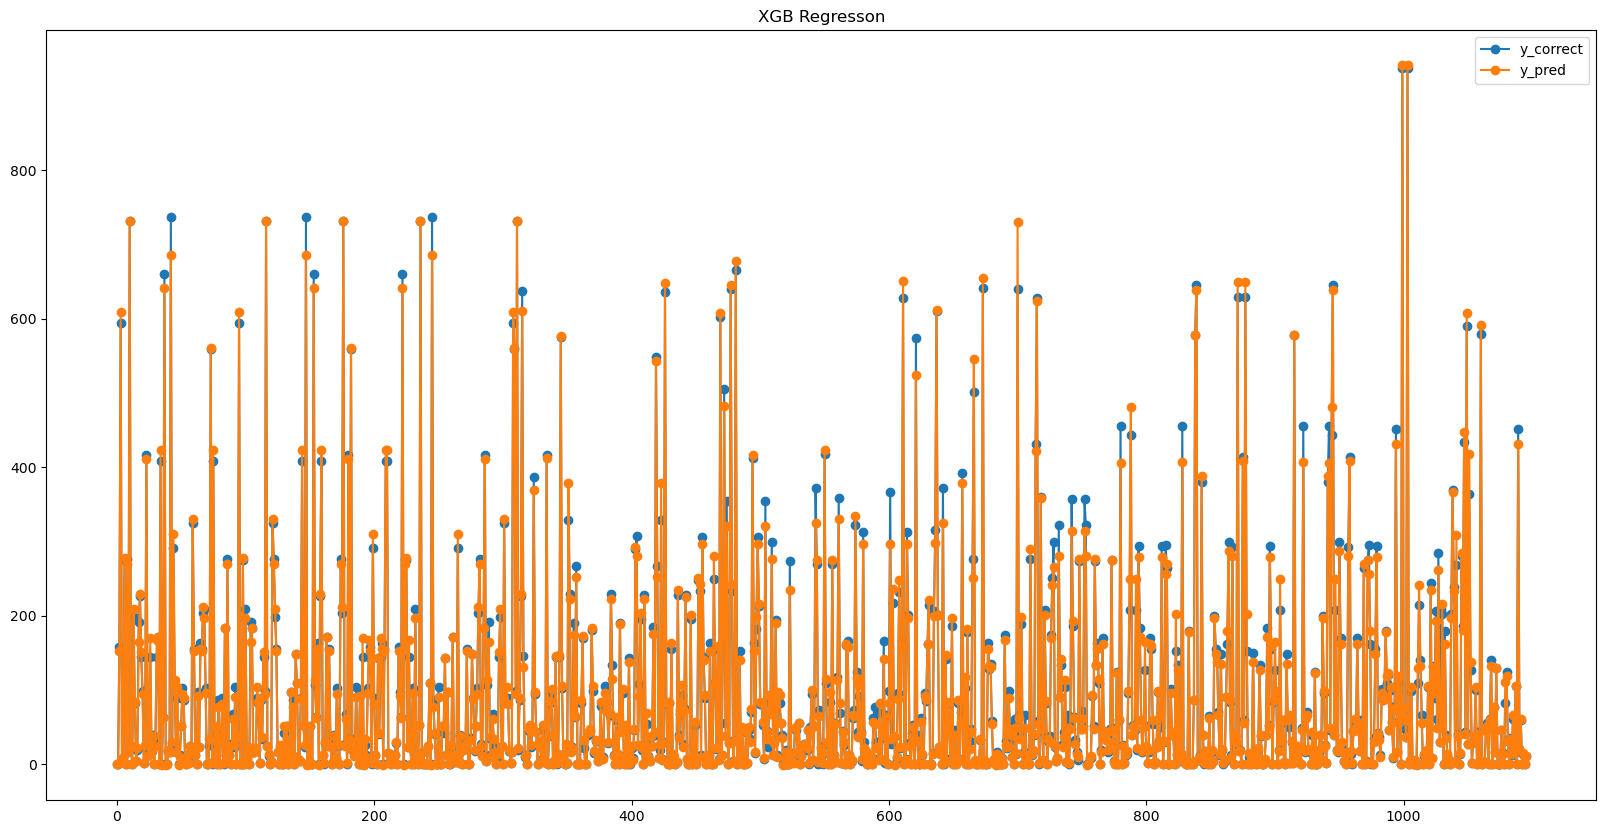

In [12]:
y_correct = y_test.reset_index(drop=True)
plt.figure(figsize=(20, 10))
plt.plot(y_correct, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('XGB Regresson')
plt.legend()
plt.show()

### 3-2. Decision Tree Regressor

In [13]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
# 모델 평가
rmse_d = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_d = metrics.mean_absolute_error(y_test, y_pred)
r2_d = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_d, mae_d, r2_d))

RMSE: 23.0315, MAE: 10.6323, R-squared: 0.9762


In [15]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# joblib.dump(model, './model/decision.pkl')

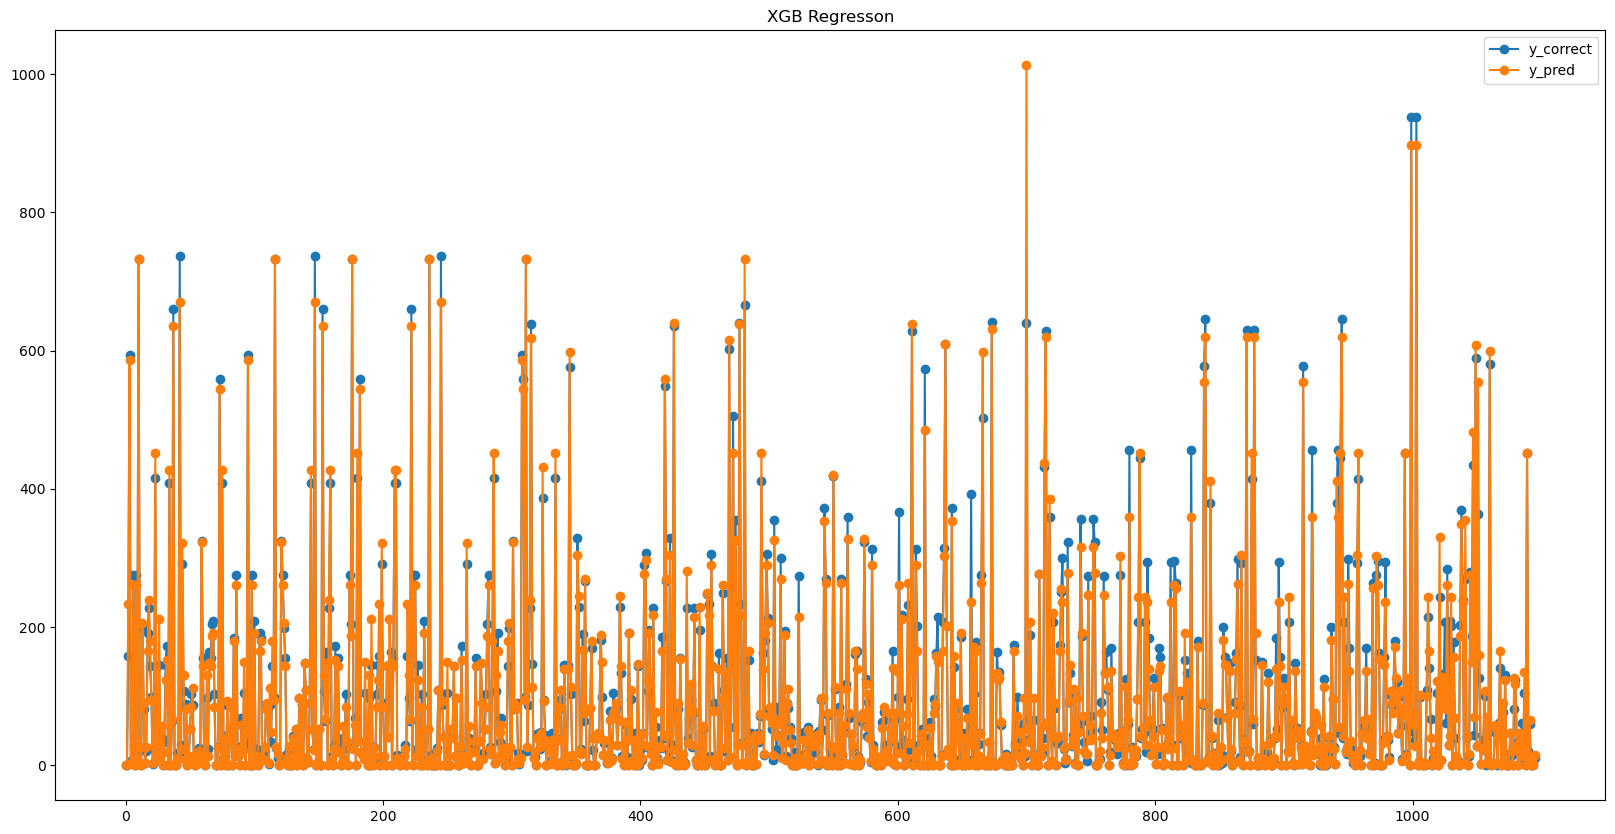

In [16]:
y_correct = y_test.reset_index(drop=True)
plt.figure(figsize=(20, 10))
plt.plot(y_correct, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('XGB Regresson')
plt.legend()
plt.show()

### 3-2. Linear Regressor

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# 모델 평가
rmse_l = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
mae_l = metrics.mean_absolute_error(y_test, y_pred)
r2_l = metrics.r2_score(y_test, y_pred)

print("RMSE: %.4f, MAE: %.4f, R-squared: %.4f" % (rmse_l, mae_l, r2_l))

RMSE: 5.6476, MAE: 1.4048, R-squared: 0.9986


In [19]:
# 모델 저장
# path = './model'
# os.makedirs(path, exist_ok=True)
# joblib.dump(model, './model/linear.pkl')

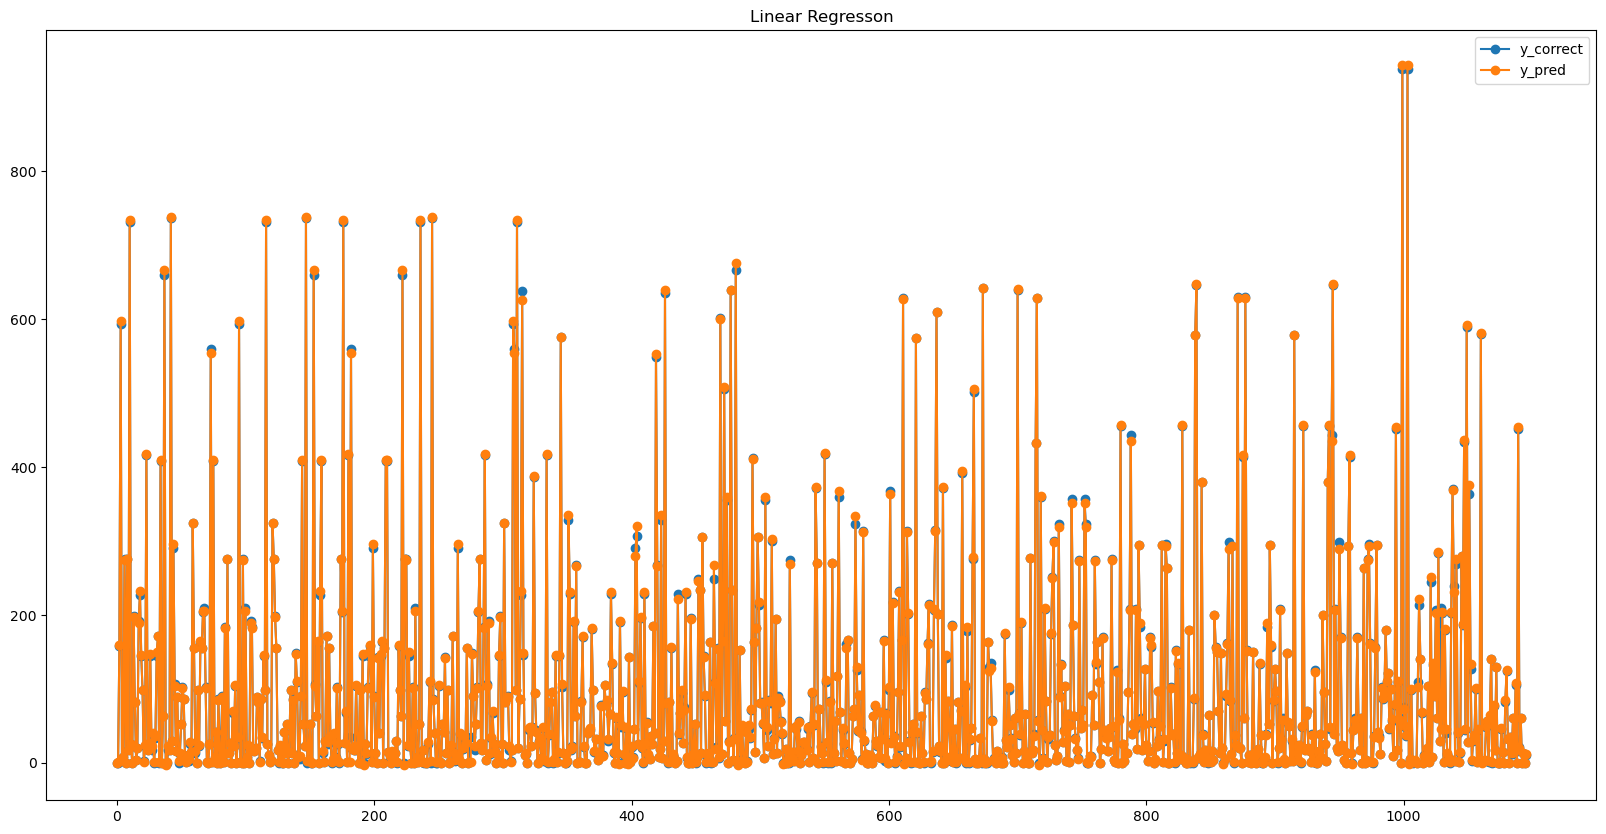

In [20]:
y_correct = y_test.reset_index(drop=True)
plt.figure(figsize=(20, 10))
plt.plot(y_correct, label='y_correct', marker='o')
plt.plot(y_pred, label='y_pred', marker='o')
plt.title('Linear Regresson')
plt.legend()
plt.show()

## 4. 결과
- Part Number를 인덱스로 활용
- 시간데이터 사용

In [21]:
df_result = pd.DataFrame({'model':['XGB', 'Decision Tree', 'Linear'],
              'RMSE':[rmse_x, rmse_d, rmse_l],
              'MAE':[mae_x, mae_d, mae_l],
              'R-suared':[r2_x, r2_d, r2_l]
             })
df_result

,model,RMSE,MAE,R-suared
0,XGB,11.931435,5.518868,0.993622
1,Decision Tree,23.031496,10.632299,0.976234
2,Linear,5.647641,1.404769,0.998571
